In [2]:
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import cv2


In [3]:
# # File paths
depth_filepath = 'data/3d_cattle_demo/renders/cow_boxed/sliding_clip_120s_v3/case=default/render=depth/front_upper/2025-08-05_173119/000021.exr'
img_filepath = 'data/3d_cattle_demo/renders/cow_boxed/sliding_clip_120s_v3/case=default/render=image/front_upper/2025-08-04_203708/000021.png'

# depth_filepath = '/home/bonting/3d_cattle_demo/data/renders/cow_boxed/sliding_clip_120s_v3/case=default/render=depth/front_upper/2025-08-06_160013/000021.exr'
# img_filepath = '/home/bonting/3d_cattle_demo/data/renders/cow_boxed/sliding_clip_120s_v3/case=default/render=image/front_upper/2025-08-06_160440/000021.png'


# Chosen point (normalized coordinates)
x_delta = 0.5  # Center of frame horizontally
y_delta = 0.5  # Center of frame vertically


In [4]:
def read_depth(filepath):
    """Read depth data from image file using OpenCV"""
    depth = cv2.imread(filepath, cv2.IMREAD_UNCHANGED)
    
    if depth is None:
        raise ValueError(f"Could not read depth image from {filepath}")
    
    height, width = depth.shape[:2]
    metadata = {}
    
    return depth, width, height, metadata


In [5]:
# Load image and depth map
img = Image.open(img_filepath)
img_array = np.array(img)

depth_map, depth_width, depth_height, exr_metadata = read_depth(depth_filepath)

print(f"Image dimensions: {img.size}")
print(f"Depth map dimensions: {depth_width} x {depth_height}")
print(f"Depth range: {depth_map.min():.3f} - {depth_map.max():.3f} meters")

# Display metadata if available
if exr_metadata:
    print("\n=== EXR Metadata ===")
    if 'camera_position' in exr_metadata:
        x, y, z = exr_metadata['camera_position']
        print(f"Camera position (world coordinates): ({x:.3f}, {y:.3f}, {z:.3f})")
    else:
        print("No camera position metadata found")
else:
    print("No custom metadata found in EXR file")

Image dimensions: (1920, 1080)
Depth map dimensions: 1920 x 1080
Depth range: 1.055 - 4.339 meters
No custom metadata found in EXR file


In [ ]:
# Extract single channel depth data (cv2 loads as 3-channel but all channels are the same)
depth_data = depth_map[:, :, 0] if len(depth_map.shape) == 3 else depth_map

print(f"Depth data shape: {depth_data.shape}")
print(f"Depth range after extraction: {depth_data.min():.3f} - {depth_data.max():.3f} meters")

Depth data shape: (1080, 1920)
Depth range after extraction: 1.055 - 4.339 meters


In [30]:
# Choose points w.r.t. front upper camera

# Farthest left corner of the room
chosen_px_x = 727
chosen_px_y = 213

# # Middle of the farthest edge of the room
# chosen_px_x = int(1920/2)
# chosen_px_y = 213

In [31]:
# # Convert normalized coordinates to pixel coordinates

# Get distance at chosen point using extracted depth data
distance_meters = depth_data[chosen_px_y, chosen_px_x]
print(f"Chosen point coordinates: ({chosen_px_y}, {chosen_px_x}) pixels")
print(f"Chosen point distance: {distance_meters:.3f} meters")
print()

max_depth_coords = np.unravel_index(np.argmax(depth_data), depth_data.shape)
max_distance_meters = depth_data[max_depth_coords]

print(f"Max depth coordinates: ({max_depth_coords[0]}, {max_depth_coords[1]}) pixels")
print(f"Max distance: {max_distance_meters:.3f} meters")

Chosen point coordinates: (213, 727) pixels
Chosen point distance: 4.339 meters

Max depth coordinates: (213, 727) pixels
Max distance: 4.339 meters


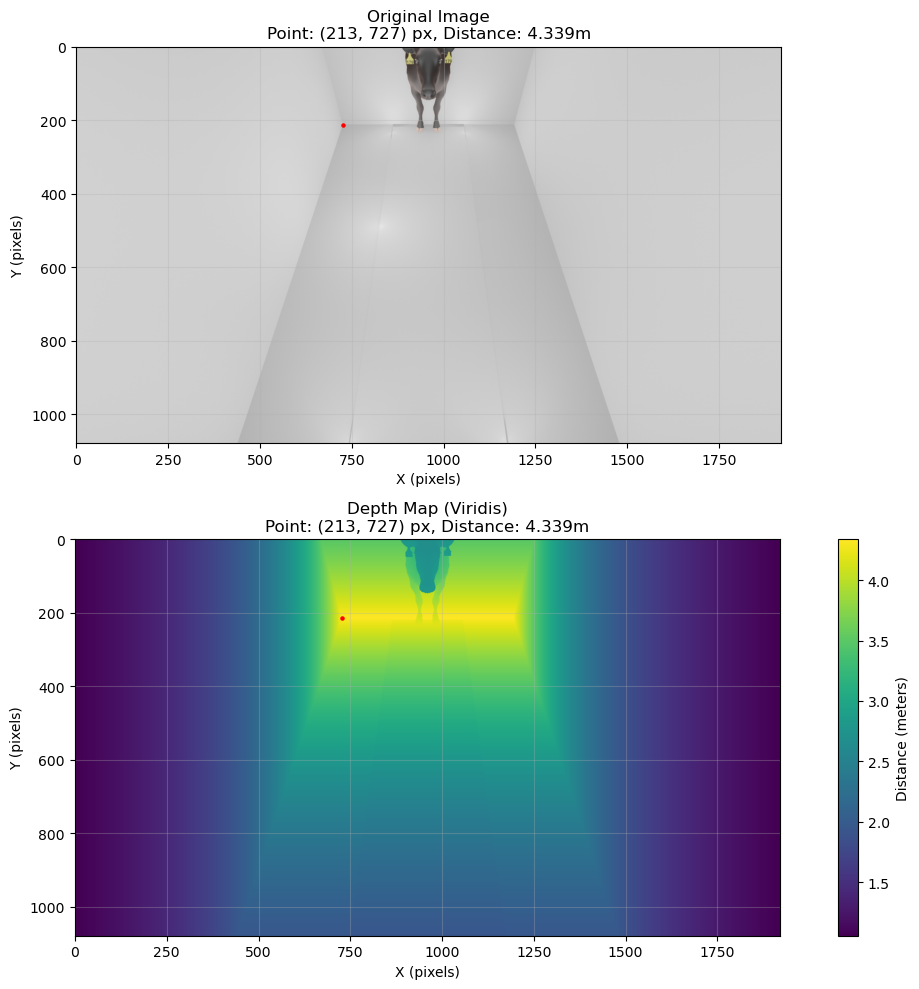

In [32]:
# Create visualization
DOT_SIZE = 5

fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 10))

# Top plot: Original image
ax1.imshow(img_array)
ax1.scatter(chosen_px_x, chosen_px_y, c='red', s=DOT_SIZE, marker='o')
ax1.set_title(f'Original Image\nPoint: ({chosen_px_y}, {chosen_px_x}) px, Distance: {distance_meters:.3f}m')
ax1.set_xlabel('X (pixels)')
ax1.set_ylabel('Y (pixels)')
ax1.grid(True, alpha=0.3)

# Bottom plot: Depth map
depth_plot = ax2.imshow(depth_data, cmap='viridis')
ax2.scatter(chosen_px_x, chosen_px_y, c='red', s=DOT_SIZE, marker='o')
ax2.set_title(f'Depth Map (Viridis)\nPoint: ({chosen_px_y}, {chosen_px_x}) px, Distance: {distance_meters:.3f}m')
ax2.set_xlabel('X (pixels)')
ax2.set_ylabel('Y (pixels)')

# Add colorbar for depth map
cbar = plt.colorbar(depth_plot, ax=ax2)
cbar.set_label('Distance (meters)')

ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()


In [34]:
import json

def load_camera_params(scene_config_path, camera_name):
    """Load camera parameters from scene_config.json file (reused from roboflow_head_demo.py)"""
    with open(scene_config_path, "r") as f:
        data = json.load(f)

    cams = data.get("cameras", {})
    if camera_name not in cams:
        available = ", ".join(cams.keys())
        raise ValueError(
            f"Camera '{camera_name}' not found in {scene_config_path}. Available: {available}"
        )
    cam = cams[camera_name]

    sensor_w_mm = float(cam["sensor_mm"]["width"])
    sensor_h_mm = float(cam["sensor_mm"]["height"])

    focal_length_mm = cam.get("focal_length_mm")

    return sensor_w_mm, sensor_h_mm, focal_length_mm

# Load actual camera parameters from scene config
scene_config_path = 'data/3d_cattle_demo/renders/cow_boxed/sliding_clip_120s_v3/scene_config.json'
camera_name = "Camera.front.upper"  # Based on the file paths used

sensor_w_mm, sensor_h_mm, focal_length_mm = load_camera_params(scene_config_path, camera_name)

print(f"Camera parameters loaded from {scene_config_path}")
print(f"  Camera: {camera_name}")
print(f"  Sensor: {sensor_w_mm:.3f}mm x {sensor_h_mm:.3f}mm")
print(f"  Focal length: {focal_length_mm:.3f}")


Camera parameters loaded from data/3d_cattle_demo/renders/cow_boxed/sliding_clip_120s_v3/scene_config.json
  Camera: Camera.front.upper
  Sensor: 5.376mm x 3.040mm
  Focal length: 2.100


In [35]:
def compute_euclidean_distance_matrix(depth_data, sensor_w_mm, sensor_h_mm, focal_length_mm):
    """
    Convert depth map to true Euclidean distance matrix.
    
    The depth values represent distance along the camera ray, but we need to convert
    to true 3D Euclidean distance from the camera center.
    
    Parameters:
    -----------
    depth_data : np.ndarray
        2D array of depth values in meters
    sensor_w_mm, sensor_h_mm : float
        Physical sensor dimensions in millimeters
    focal_x_mm, focal_y_mm : float
        Focal length in millimeters
    
    Returns:
    --------
    np.ndarray
        2D array of true Euclidean distances in meters
    """
    h, w = depth_data.shape
    
    # Convert focal length from mm to pixels
    fx_px = focal_length_mm * w / sensor_w_mm
    fy_px = focal_length_mm * h / sensor_h_mm
    
    # Create coordinate grids
    u_coords, v_coords = np.meshgrid(np.arange(w), np.arange(h))
    
    # Convert to normalized coordinates (relative to image center)
    u = u_coords - w / 2.0
    v = v_coords - h / 2.0
    
    # Calculate scale factor for each pixel
    scale = np.sqrt(1.0 + (u / fx_px) ** 2 + (v / fy_px) ** 2)
    
    # Convert depth to true Euclidean distance
    euclidean_distances = depth_data * scale
    
    return euclidean_distances

print("Euclidean distance calculation function defined")


Euclidean distance calculation function defined


In [36]:
# Compute the Euclidean distance matrix using actual camera parameters
euclidean_dist_matrix = compute_euclidean_distance_matrix(
    depth_data, sensor_w_mm, sensor_h_mm, focal_length_mm
)

print(f"Euclidean distance matrix computed using real camera parameters:")
print(f"  Camera: {camera_name}")
print(f"  Sensor: {sensor_w_mm:.3f}mm x {sensor_h_mm:.3f}mm")
print(f"  Focal length: {focal_length_mm:.3f}mm")
print(f"Shape: {euclidean_dist_matrix.shape}")
print(f"Distance range: {euclidean_dist_matrix.min():.3f} - {euclidean_dist_matrix.max():.3f} meters")
print(f"Mean distance: {euclidean_dist_matrix.mean():.3f} meters")

# Compare with original depth at the chosen point
raw_depth_at_point = depth_data[chosen_px_y, chosen_px_x]
euclidean_dist_at_point = euclidean_dist_matrix[chosen_px_y, chosen_px_x]
difference = euclidean_dist_at_point - raw_depth_at_point

print(f"\nAt chosen point ({chosen_px_y}, {chosen_px_x}):")
print(f"  Raw depth: {raw_depth_at_point:.3f} meters")
print(f"  Euclidean distance: {euclidean_dist_at_point:.3f} meters") 
print(f"  Difference: {difference:.3f} meters ({difference/raw_depth_at_point*100:.1f}% increase)")


Euclidean distance matrix computed using real camera parameters:
  Camera: Camera.front.upper
  Sensor: 5.376mm x 3.040mm
  Focal length: 2.100mm
Shape: (1080, 1920)
Distance range: 1.713 - 4.926 meters
Mean distance: 2.633 meters

At chosen point (213, 727):
  Raw depth: 4.339 meters
  Euclidean distance: 4.926 meters
  Difference: 0.587 meters (13.5% increase)


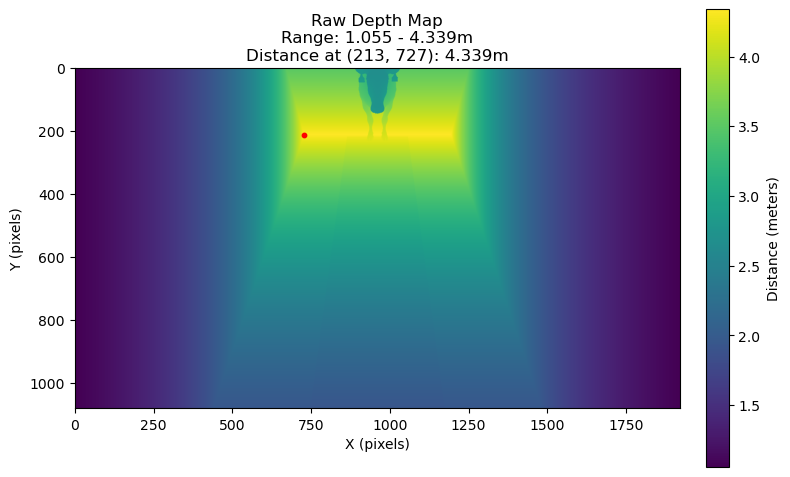

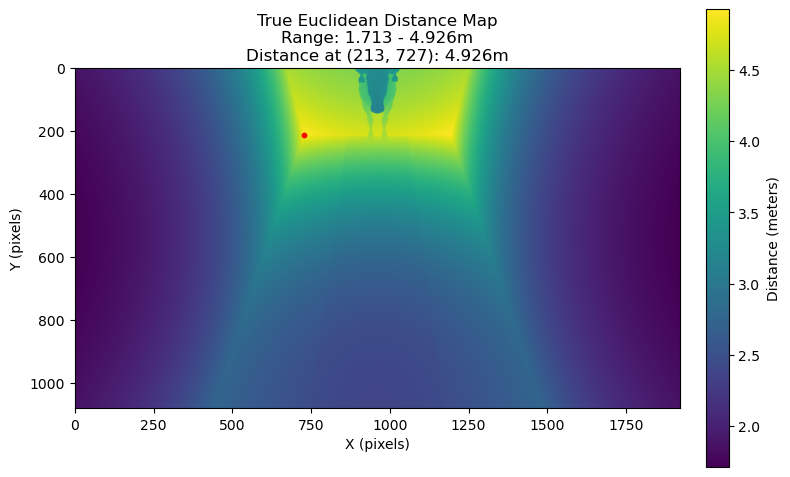

In [37]:
# Visualize only the raw depth and Euclidean distance maps on separate figures

raw_depth_at_point = depth_data[chosen_px_y, chosen_px_x]
euclidean_dist_at_point = euclidean_dist_matrix[chosen_px_y, chosen_px_x]

fig1, ax1 = plt.subplots(figsize=(8, 7))
depth_plot1 = ax1.imshow(depth_data, cmap='viridis')
ax1.scatter(chosen_px_x, chosen_px_y, c='red', s=10, marker='o')
ax1.set_title(
    f'Raw Depth Map\nRange: {depth_data.min():.3f} - {depth_data.max():.3f}m\n'
    f'Distance at ({chosen_px_y}, {chosen_px_x}): {raw_depth_at_point:.3f}m'
)
ax1.set_xlabel('X (pixels)')
ax1.set_ylabel('Y (pixels)')
cbar1 = plt.colorbar(depth_plot1, ax=ax1, label='Distance (meters)', fraction=0.035, pad=0.04)
plt.tight_layout()
plt.show()

fig2, ax2 = plt.subplots(figsize=(8, 7))
euclidean_plot = ax2.imshow(euclidean_dist_matrix, cmap='viridis')
ax2.scatter(chosen_px_x, chosen_px_y, c='red', s=10, marker='o')
ax2.set_title(
    f'True Euclidean Distance Map\nRange: {euclidean_dist_matrix.min():.3f} - {euclidean_dist_matrix.max():.3f}m\n'
    f'Distance at ({chosen_px_y}, {chosen_px_x}): {euclidean_dist_at_point:.3f}m'
)
ax2.set_xlabel('X (pixels)')
ax2.set_ylabel('Y (pixels)')
cbar2 = plt.colorbar(euclidean_plot, ax=ax2, label='Distance (meters)', fraction=0.035, pad=0.04)
plt.tight_layout()
plt.show()


# Compute projected distance to the chosen point

In [40]:
import math

# -------  camera intrinsics (edit to match your camera) -------
# TODO: read from scene_config.json
FOCAL_LENGTH_MM = 2.1           # f
SENSOR_WIDTH_MM = 5.376         # W
SENSOR_HEIGHT_MM = 3.040        # H
RES_X = 1920                    # Nx  (Full-HD width)
RES_Y = 1080                    # Ny  (Full-HD height)
# --------------------------------------------------------------

def pixel_to_angles(px, py,
                    f_mm=FOCAL_LENGTH_MM,
                    sw_mm=SENSOR_WIDTH_MM,
                    sh_mm=SENSOR_HEIGHT_MM,
                    nx=RES_X,
                    ny=RES_Y):
    """
    Return (px2principal_x_deg, px2principal_y_deg) of pixel (px, py) w.r.t. optical axis.
    px,py : 0-based pixel coordinates (origin at top-left, x→, y↓)
    """
    # principal point (centre pixel)
    cx, cy = (nx) / 2.0, (ny) / 2.0

    # mm-offsets of that pixel on the sensor plane
    x_mm = (px - cx) * (sw_mm / nx)
    y_mm = (cy - py) * (sh_mm / ny)   # flip sign: screen y↓ ↔ optical y↑

    # angles
    yaw_deg   = math.degrees(math.atan2(x_mm, f_mm))
    pitch_deg = math.degrees(math.atan2(y_mm, f_mm))
    return yaw_deg, pitch_deg

In [41]:
# Choose points w.r.t. front upper camera

# Farthest left corner of the room
chosen_px_x = 727
chosen_px_y = 213

# # Middle of the farthest edge of the room
# chosen_px_x = int(1920/2)
# chosen_px_y = 213

In [42]:
yaw_deg, pitch_deg = pixel_to_angles(chosen_px_x, chosen_px_y)

print(f"Chosen pixel (x={chosen_px_x}, y={chosen_px_y})")
print(f"yaw (horizontal) = {yaw_deg:+.2f}°")
print(f"pitch (vertical) = {pitch_deg:+.2f}°")
print()

A_prime_B = euclidean_dist_matrix[chosen_px_y, chosen_px_x]
print(f"A'B: {A_prime_B:.3f} m")

AB = A_prime_B * np.cos(np.deg2rad(yaw_deg))
print(f"AB: {AB:.3f} m")
print()

gamma_deg = 36.0
delta_deg = pitch_deg
alpha_deg = 90 - (delta_deg + gamma_deg)

print(f"gamma: {gamma_deg:.2f}°")
print(f"delta: {delta_deg:.2f}°")
print(f"alpha: {alpha_deg:.2f}°")
print()

BC = AB * np.cos(np.deg2rad(alpha_deg))

print(f"AB: {AB:.3f} m")
print(f"BC: {BC:.3f} m")

Chosen pixel (x=727, y=213)
yaw (horizontal) = -17.26°
pitch (vertical) = +23.67°

A'B: 4.926 m
AB: 4.704 m

gamma: 36.00°
delta: 23.67°
alpha: 30.33°

AB: 4.704 m
BC: 4.060 m
